In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.style.use("fivethirtyeight")

path = ""

In [2]:
# Uncomment cell if using Google Colab

from google.colab import drive
drive.mount("/content/drive")

path = "/content/drive/My Drive/csc-461-final-project/"

Mounted at /content/drive


In [3]:
Statewide = pd.read_csv(path + "data/Statewide.csv")
Statewide.head()

,CITY,ZIP CODE,CURRENT PARTY,YEAR OF BIRTH,ELECTION 3,ELECTION 4,ELECTION 5,ELECTION 6,ELECTION 7,ELECTION 8,PARTY 5,PARTY 6,PARTY 8,TGT STATEWIDE PRIMARY,TGT PARTY AFFILIATION
0,6,2921,1,1962,1,1,1,0,1,1,3,0,2,0,0
1,6,2920,2,1984,0,1,0,0,0,0,0,0,0,0,0
2,32,2878,3,1968,1,1,0,1,1,1,0,3,3,1,3
3,32,2878,3,1962,1,1,0,1,1,0,0,3,0,1,3
4,34,2889,3,1996,0,1,0,0,0,0,0,0,0,0,0


In [4]:
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

In [5]:
Statewide_target = Statewide["TGT STATEWIDE PRIMARY"]
Statewide = Statewide.drop(["TGT STATEWIDE PRIMARY", "TGT PARTY AFFILIATION"], axis = 1)

In [6]:
Statewide.head()

,CITY,ZIP CODE,CURRENT PARTY,YEAR OF BIRTH,ELECTION 3,ELECTION 4,ELECTION 5,ELECTION 6,ELECTION 7,ELECTION 8,PARTY 5,PARTY 6,PARTY 8
0,6,2921,1,1962,1,1,1,0,1,1,3,0,2
1,6,2920,2,1984,0,1,0,0,0,0,0,0,0
2,32,2878,3,1968,1,1,0,1,1,1,0,3,3
3,32,2878,3,1962,1,1,0,1,1,0,0,3,0
4,34,2889,3,1996,0,1,0,0,0,0,0,0,0


In [7]:
Statewide_target.head()

0    0
1    0
2    1
3    1
4    0
Name: TGT STATEWIDE PRIMARY, dtype: int64

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

X_train, X_test, y_train, y_test = train_test_split(Statewide, Statewide_target, test_size = .50, stratify = Statewide_target)

print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)

baggingClassifier = BaggingClassifier()
n_estimators = np.arange(10, 100, 10).tolist()
max_samples = [0.05, 0.1, 0.2, 0.5]
param_grid = dict(n_estimators = n_estimators, max_samples = max_samples)
print(param_grid)

cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3)
rand = RandomizedSearchCV(estimator = baggingClassifier, param_distributions = param_grid, cv = cv, scoring = "average_precision", return_train_score = True, verbose = 10)

rand_search = rand.fit(X_train, y_train)


Train features shape: (408148, 13)
Test features shape: (408149, 13)
{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90], 'max_samples': [0.05, 0.1, 0.2, 0.5]}
Fitting 30 folds for each of 10 candidates, totalling 300 fits
[CV 1/30; 1/10] START max_samples=0.2, n_estimators=90..........................
[CV 1/30; 1/10] END max_samples=0.2, n_estimators=90;, score=(train=0.792, test=0.630) total time=  30.9s
[CV 2/30; 1/10] START max_samples=0.2, n_estimators=90..........................
[CV 2/30; 1/10] END max_samples=0.2, n_estimators=90;, score=(train=0.791, test=0.637) total time=  30.5s
[CV 3/30; 1/10] START max_samples=0.2, n_estimators=90..........................
[CV 3/30; 1/10] END max_samples=0.2, n_estimators=90;, score=(train=0.792, test=0.629) total time=  27.9s
[CV 4/30; 1/10] START max_samples=0.2, n_estimators=90..........................
[CV 4/30; 1/10] END max_samples=0.2, n_estimators=90;, score=(train=0.792, test=0.633) total time=  28.0s
[CV 5/30; 1/10] START max_s

In [19]:
print(rand_search.best_params_)
print('Mean test score: {}'.format(rand_search.cv_results_['mean_test_score']))
print('Mean train score: {}'.format(rand_search.cv_results_['mean_train_score']))

{'n_estimators': 60, 'max_samples': 0.1}
Mean test score: [0.63033957 0.59188807 0.58503682 0.62725647 0.64094606 0.59458959
 0.59806881 0.62973493 0.62882576 0.63260124]
Mean train score: [0.79179528 0.85564895 0.67711546 0.7887919  0.73905745 0.85725137
 0.86022101 0.79100523 0.72701126 0.68750702]


In [10]:
accuracy = rand_search.best_score_
print("Best AUC-PR: {}".format(accuracy))

Best AUC-PR: 0.6409460595093126


In [ ]:
%pip install wandb

In [ ]:
import wandb
wandb.login
wandb.init(config=rand_search.best_params_)

In [21]:
bestBagging = BaggingClassifier(**rand_search.best_params_)
bestBagging.fit(X_train, y_train)
test_pred = bestBagging.predict(X_test)
test_proba = bestBagging.predict_proba(X_test)
test_accuracy = roc_auc_score(y_test, bestBagging.predict_proba(X_test)[:,1])

print("AUC-ROC: {}".format(test_accuracy))
print("AUC-PR {}".format(sklearn.metrics.average_precision_score(y_test, bestBagging.predict_proba(X_test)[:,1])))

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef

print('\nF1 Score: {}'.format(
    f1_score(y_test, test_pred, average = "weighted")))
print('Precision: {}'.format(
    precision_score(y_test, test_pred, average = "weighted")))
print('Recall: {}'.format(
    recall_score(y_test, test_pred, average = "weighted")))
print('Accuracy: {}'.format(
    accuracy_score(y_test, test_pred)))
print('MCC: {}'.format(
    matthews_corrcoef(y_test, test_pred)))

AUC-ROC: 0.8813563495215012
AUC-PR 0.6409956157375398

F1 Score: 0.8680342662680858
Precision: 0.8663294554203042
Recall: 0.8767533425293214
Accuracy: 0.8767533425293214
MCC: 0.512749255064302


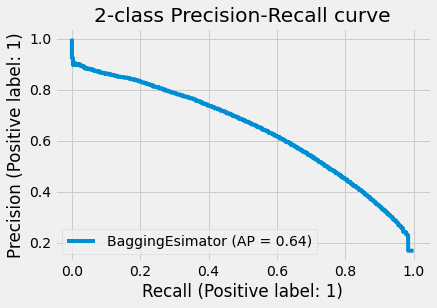

In [22]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    bestBagging, X_test, y_test, name="BaggingEsimator"
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

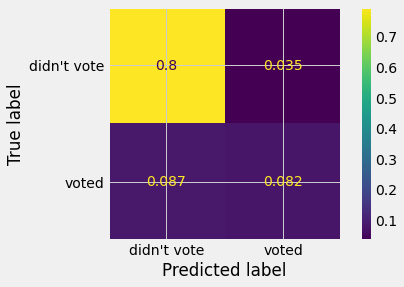

In [15]:
cm = confusion_matrix(y_test, test_pred, normalize = "all", labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["didn't vote", "voted"])
wandb.sklearn.plot_confusion_matrix(y_test, test_pred, ["didn't vote", "voted"]) 
disp.plot()
plt.show()

In [ ]:

wandb.sklearn.plot_classifier(bestBagging, X_train, X_test, y_train, y_test, test_pred, test_proba, ["didn't vote", "voted"], model_name='DecisionTree', feature_names = X_train.columns)

In [ ]:
wandb.finish()